# Lecture 3: Confidence Intervals via Bootstrapping

## Today's Learning Goals

By the end of this lecture, you should be able to:

1. Define what a confidence interval is and why we want to generate one.
2. Explain how the bootstrap sampling distribution can be used to create confidence intervals.
3. Write a computer script to calculate confidence intervals for a population parameter using bootstrapping.
4. Effectively visualize point estimates and confidence intervals.
5. Interpret and explain results from confidence intervals.

## Loading `R` Packages

Let us load the libraries for data wrangling, analysis, and plotting.

In [1]:
library(cowplot)
library(infer)
library(scales)
library(tidyverse)
options(repr.matrix.max.rows = 6)

── Attaching packages ───────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ──────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



## 1. Fundamentals of Confidence Intervals

A confidence interval is a plausible range of values for the population parameter **under a certain percentage of confidence**.

```{figure} https://d33wubrfki0l68.cloudfront.net/45f6d2e16255dbcb42de86336e1e49ef732aa5da/8bcd0/images/shutterstock/point_estimate_vs_conf_int.png
:height: 300px
:name: CI_analogy

Image from [*Ismay and Kim (2021)*](https://moderndive.com/8-confidence-intervals.html#ci-build-up): Figure 8.15.
```

### 1.1. Why confidence intervals?

- If we report a point estimate, we probably will not hit the exact value of the population parameter.
- If we report a range of plausible values, we have a good shot at capturing the parameter.

### 1.2. Bootstrap confidence intervals with the percentile method

One way to calculate a range of plausible values for the population parameter (**to be estimated!**) is using the middle 95% of the distribution of bootstrap sample estimates to determine our endpoints:

- Our endpoints are at the 2.5th and 97.5th percentiles.
- For the bootstrap distribution below, the values of 21 and 29.3.

```{figure} https://d33wubrfki0l68.cloudfront.net/91c9a705060594c5aeae5fe2b01256f688cee535/5e3a4/ismaykim_files/figure-html/unnamed-chunk-301-1.png
:height: 400px
:name: CI_example

Example of a bootstrap confidence interval.
```

### 1.3. What does a 95% confidence interval mean? 

It means that if we were to repeat the process of sampling and calculating a 95% confidence interval multiple times, 95% of the time, we would expect our population parameter's value to lie within the confidence interval. We will check what this means in practice during this lecture.

### 1.4. Why 95%? 

95% is the standard level of confidence in Statistics. Other typical levels are 90 and 99%. If we hold everything else constant (e.g., sample size $n$), a higher confidence level corresponds to a wider confidence interval and a lower confidence level to a narrower confidence interval. The chosen level depends on the downstream analysis and what chances we are willing to take of being wrong.

## 2. Calculating Confidence Intervals in `R`

The `infer` package has a function called `get_confidence_interval()` that we can use to compute confidence intervals.

### 2.1. The Airbnb Dataset

Let us use the `listings` data. Suppose we are interested in the **population** proportion corresponding to those `listings` involving the *entire home/apartment*, $\pi_E$.

#### 2.1.1. Loading the Population Data Set

The **population** data `listings` contains an `id` number, neighbourhood, type of room, the number of people the rental accommodates, number of bathrooms, bedrooms, beds, and the `price` per night.

In [2]:
listings <- read_csv("data/listings.csv")

Rows: 4938 Columns: 74
── Column specification ──────────────────────────────────────────────────────────
Delimiter: ","
chr  (24): listing_url, name, description, neighborhood_overview, picture_ur...
dbl  (37): id, scrape_id, host_id, host_listings_count, host_total_listings_...
lgl   (8): host_is_superhost, host_has_profile_pic, host_identity_verified, ...
date  (5): last_scraped, host_since, calendar_last_scraped, first_review, la...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We will select the columns corresponding `id`, `room_type`, and `price` per night. **The variable `price` will also be used at the end of this lecture.**

In [3]:
listings <- listings |>
  select(id, room_type, price) |>
  mutate(room_type = as.factor(room_type), price = as.numeric(gsub('[$,]','', price)))
listings # N = 4,938 (Population Size)

id,room_type,price
<dbl>,<fct>,<dbl>
10080,Entire home/apt,150
13357,Entire home/apt,132
13358,Entire home/apt,85
⋮,⋮,⋮
45398550,Private room,53.29
45400161,Entire home/apt,145.00
45401776,Entire home/apt,135.00


#### 2.1.2. Calculating the true $\pi_E$

For the sake of our example, we already know that $\pi_E = 0.756$.

In [4]:
listings |>
  group_by(room_type) |>
  summarise(n = n()) |>
  mutate(freq = round(n / sum(n), 3))

room_type,n,freq
<fct>,<int>,<dbl>
Entire home/apt,3731,0.756
Hotel room,4,0.001
Private room,1179,0.239
Shared room,24,0.005


Since we are interested in `room_type` `Entire home/apt`, let us rename the other levels as `Other`. Function `recode_factor()` from `dplyr` can be used for this purpose.

In [5]:
listings$room_type <- recode_factor(listings$room_type,
  `'Entire home/apt'` = "Entire home/apt", 
  `Hotel room` = "Other", 
  `Private room` = "Other", 
  `Shared room` = "Other"
)

listings |>
  group_by(room_type) |>
  summarise(n = n()) |>
  mutate(freq = round(n / sum(n), 3))

room_type,n,freq
<fct>,<int>,<dbl>
Entire home/apt,3731,0.756
Other,1207,0.244


#### 2.1.3. First things first!

To start with our inferential inquiry, we will draw a random sample of size $n = 40$.

In [6]:
set.seed(552) # For reproducibility.
sample <- rep_sample_n(listings, size = 40)
sample

replicate,id,room_type,price
<int>,<dbl>,<fct>,<dbl>
1,28390229,Entire home/apt,94
1,26356375,Entire home/apt,200
1,43480074,Entire home/apt,171
⋮,⋮,⋮,⋮
1,19894347,Entire home/apt,95.00
1,31864754,Entire home/apt,87.86
1,26308916,Entire home/apt,150.00


We can see that the base sample estimate is $\hat{\pi}_E = 0.8$.

In [7]:
sample |>
  group_by(room_type) |>
  summarise(n = n()) |>
  mutate(freq = round(n / sum(n), 3))

room_type,n,freq
<fct>,<int>,<dbl>
Entire home/apt,32,0.8
Other,8,0.2


### 2.2. Bootstraping with `infer`

Using `sample`, we will draw $b = 1,000$ bootstrap samples of size $n = 40$. Then, we will obtain the corresponding $b = 1,000$ `bootstrap_estimates` $\hat{\pi}_{E}^{(B)}$.

$$
X_i^{(B)} =
\begin{cases}
1 \; \; \; \; \text{if the listing is an entire home or apartment in the bootstrap sample},\\
0 \; \; \; \; \mbox{otherwise}.
\end{cases}
$$

$$\hat{\pi}_{E}^{(B)} = \frac{\sum_{i = 1}^n X_i^{(B)}}{n}.$$

In [8]:
set.seed(552) # For reproducibility.
bootstrap_estimates <- sample |>
  specify(response = room_type, success = "Entire home/apt") |>
  generate(reps = 1000, type = "bootstrap") |>
  calculate(stat = "prop")
bootstrap_estimates

replicate,stat
<int>,<dbl>
1,0.800
2,0.775
3,0.800
⋮,⋮
998,0.800
999,0.675
1000,0.750


### 2.3. Plotting the bootstrap distribution

We can make a histogram with the `bootstrap_estimates` (the red line indicates the real $\pi_E$, where the blue line shows the estimated $\hat{\pi}_E$). Note the bootstrap sampling distribution is left-skewed with respect to $\pi_E$, but centred around $\hat{\pi}_E$.

In [9]:
options(repr.plot.width = 15, repr.plot.height = 5)

bootstrap_dist_plot <- bootstrap_estimates |>
  ggplot(aes(x = stat)) +
  geom_histogram(binwidth = 0.025, color = "gray", fill = "lightgray") +
  labs(x = "Bootstrap Sample Proportions Based on n = 40", y = "Counts") +
  ggtitle("Bootstrap Distribution") +
  theme(text = element_text(size = 16.5)) +
  geom_vline(xintercept = 0.756, color = "red", size = 1.5) +
  geom_vline(xintercept = 0.8, color = "blue", size = 1.5) +
  annotate("text", x = 0.73, y = 125, label = expression(pi["E"] ~ "= 0.756"), size = 7, color = "red") +
  annotate("text", x = 0.82, y = 125, label = expression(hat(pi)["E"] ~ "= 0.8"), size = 7, color = "blue")

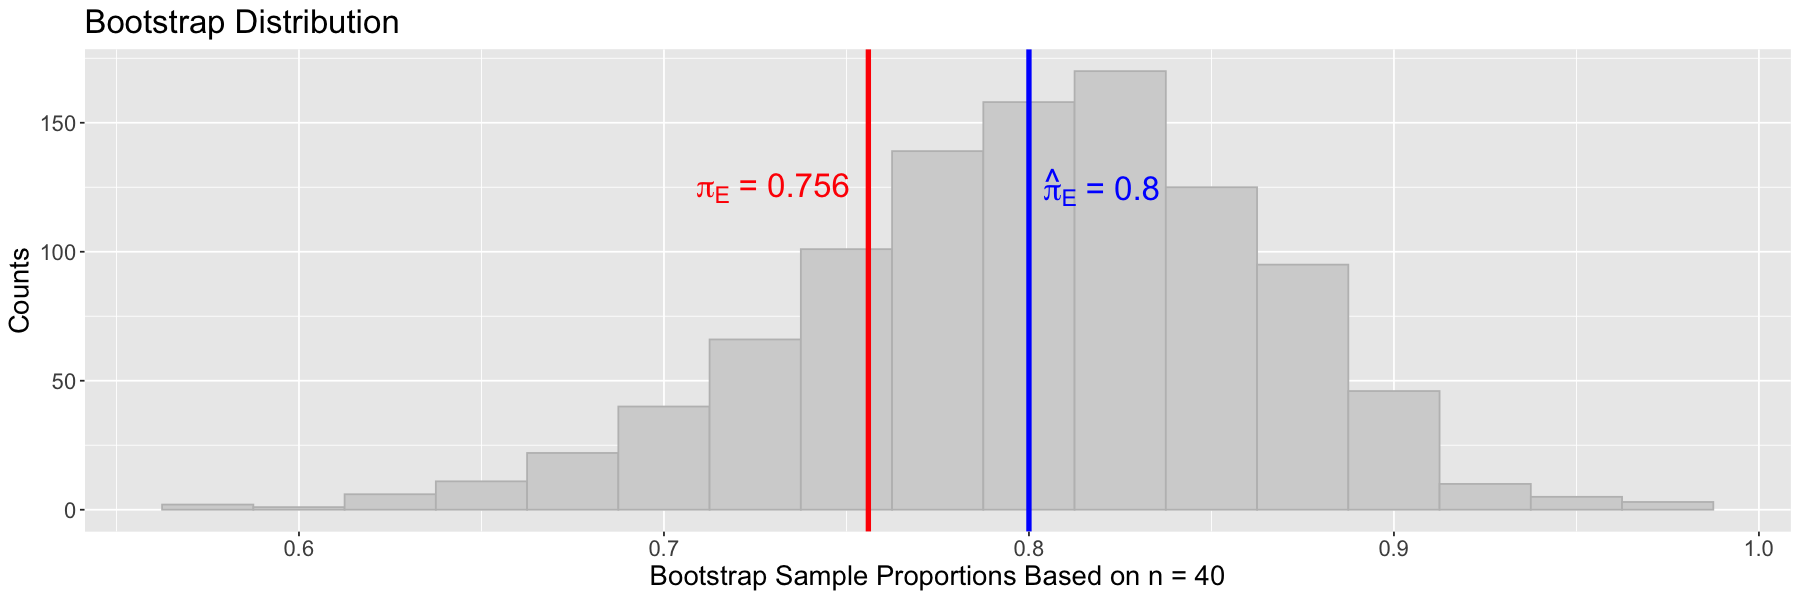

In [10]:
suppressWarnings(print(bootstrap_dist_plot))

### 2.4. Calculating bootstrap confidence intervals with `infer`

Let us use `get_confidence_interval()` to calculate the 95% confidence intervals using the percentile method:

In [11]:
ci_95 <- bootstrap_estimates |>
  get_confidence_interval(level = 0.95, type = "percentile")
ci_95

lower_ci,upper_ci
<dbl>,<dbl>
0.675,0.9


What if we wanted 99% confidence intervals?

In [12]:
ci_99 <- bootstrap_estimates |> 
  get_confidence_interval(level = 0.99, type = "percentile")
ci_99

lower_ci,upper_ci
<dbl>,<dbl>
0.625,0.95


What about 90%?

In [13]:
ci_90 <- bootstrap_estimates |> 
  get_confidence_interval(level = 0.90, type = "percentile")
ci_90

lower_ci,upper_ci
<dbl>,<dbl>
0.7,0.9


```{attention}
Lower confidence levels correspond to narrower confidence intervals **while holding everything else constant**.
```

### 2.5. Visualizing the 95% confidence intervals on the boostrap distribution

The infer package has a handy function called `shade_confidence_interval()`, which needs the corresponding `endpoints` (i.e., the lower and upper bounds).

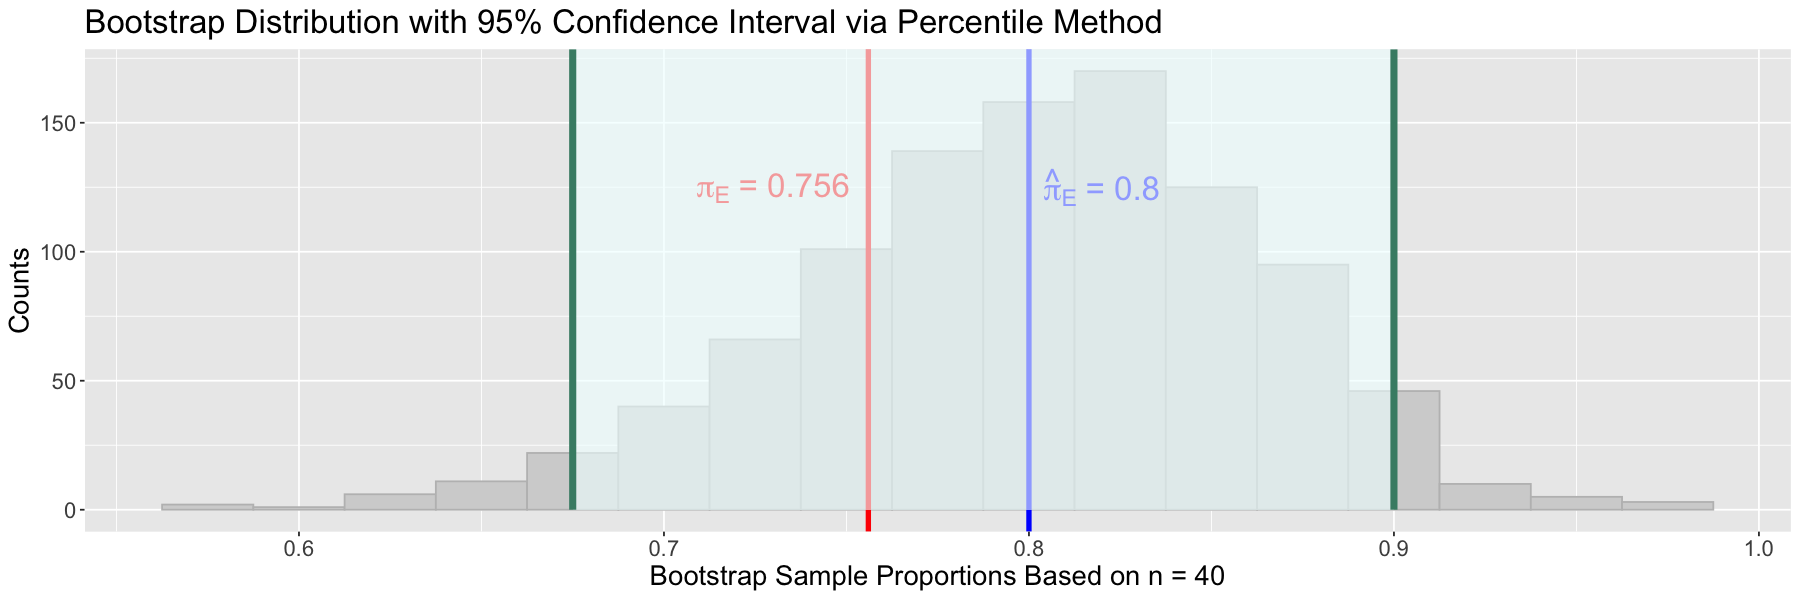

In [14]:
bootstrap_dist_plot_ci_95 <- bootstrap_dist_plot + 
  shade_confidence_interval(endpoints = ci_95, color = "aquamarine4", fill = "azure") + 
  ggtitle("Bootstrap Distribution with 95% Confidence Interval via Percentile Method")
suppressWarnings(print(bootstrap_dist_plot_ci_95))

### 2.6. Visualizing different levels of confidence

Let us see how the width of the confidence interval changes based on our confidence level. As we previously noted, the interval width increases as we increase the level of confidence **while holding everything else constant such as the base sample size $n$**. Suppose you want a narrower interval (i.e., more precise!) without increasing your base sample size $n$. Then, you will need to sacrifice a certain level of confidence.

In [15]:
bootstrap_dist_plot_ci_90 <- bootstrap_dist_plot + 
  shade_confidence_interval(endpoints = ci_90, "aquamarine4", fill = "azure") + 
  ggtitle("Bootstrap Distribution with 90% Confidence Interval via Percentile Method")

bootstrap_dist_plot_ci_99 <- bootstrap_dist_plot + 
  shade_confidence_interval(endpoints = ci_99, "aquamarine4", fill = "azure") + 
  ggtitle("Bootstrap Distribution with 99% Confidence Interval via Percentile Method")

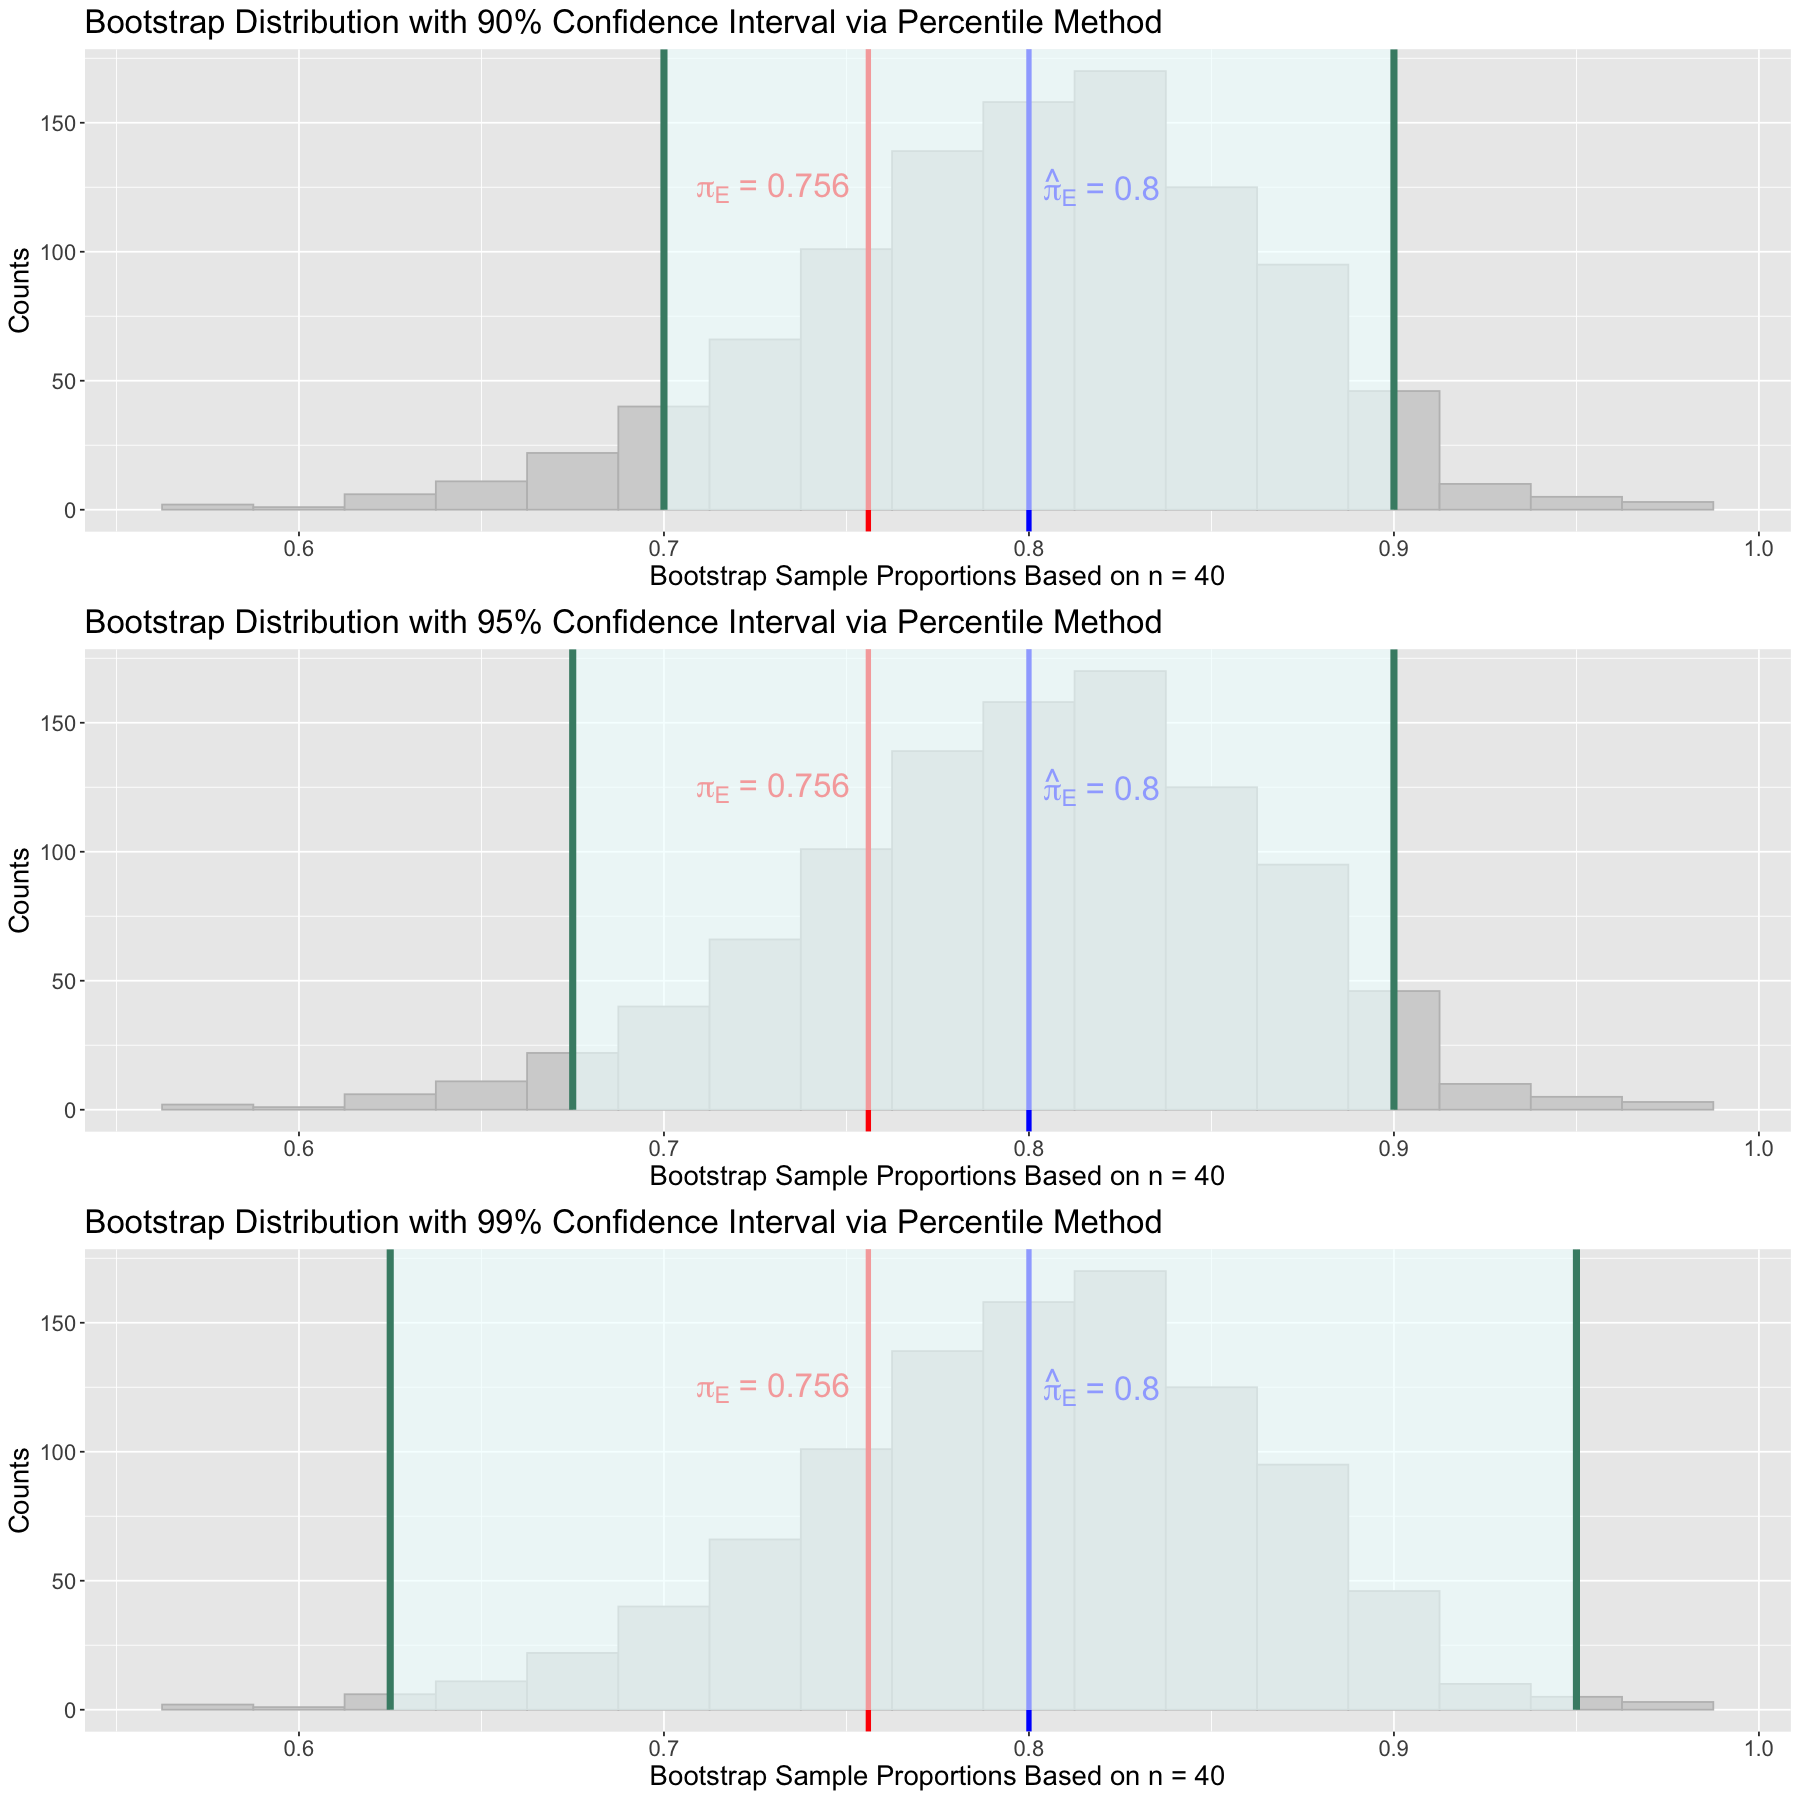

In [16]:
options(repr.plot.width = 15, repr.plot.height = 15)

suppressWarnings(print(plot_grid(bootstrap_dist_plot_ci_90, bootstrap_dist_plot_ci_95, bootstrap_dist_plot_ci_99, ncol = 1)))

**Alternatively**: as we increase our confidence interval to be more "*certain*" that the value for our population parameter of interest that we are trying to estimate falls in that plausible range, we widen it. 

### 2.7. Interpreting our confidence interval

Recall our 95% confidence interval:

In [17]:
ci_95

lower_ci,upper_ci
<dbl>,<dbl>
0.675,0.9


We used boostrapping to come up with this range of plausible values for the **population** proportion corresponding to those `listings` involving the *entire home/apartment* class

$$\pi_E = 0.756.$$

**If we had a different sample of size $n = 40$ and constructed a 95% confidence interval, would it contain the population parameter value as well?**

Let us run another simulation!

### 2.8. Confidence Interval Simulation

Let us calculate $m = 100$ different confidence intervals derived from $m = 100$ different random samples drawn from `listings` and see how many times the confidence intervals contain the true population parameter $\pi_E$.

#### Step 1: Get $m = 100$ `listings_samples` of $n$ = 40

We use the `rep_sample_n()` function and `nest()` the samples in the tibble `listing_samples`.

In [18]:
set.seed(552) # For reproducibility.
listing_samples <- listings |>
  rep_sample_n(size = 40, reps = 100, replace = FALSE) |>
  nest()
print(listing_samples)

# A tibble: 100 × 2
# Groups:   replicate [100]
   replicate data             
       <int> <list>           
 1         1 <tibble [40 × 3]>
 2         2 <tibble [40 × 3]>
 3         3 <tibble [40 × 3]>
 4         4 <tibble [40 × 3]>
 5         5 <tibble [40 × 3]>
 6         6 <tibble [40 × 3]>
 7         7 <tibble [40 × 3]>
 8         8 <tibble [40 × 3]>
 9         9 <tibble [40 × 3]>
10        10 <tibble [40 × 3]>
# … with 90 more rows


#### Step 2: Create a function for boostrap confidence intervals for each `base_sample`

For a **binary-type** variable, the function `ci_pipeline` takes a **single** `base_sample` fo size $n$ and draws `1000` bootstrap samples. It computes the **estimated proportion** of interest and then its 95% bootstrap confidence interval.

In [19]:
ci_pipeline <- function(base_sample) {
  set.seed(552)
    
  base_sample |>
    specify(response = room_type, success = "Entire home/apt") |>
    generate(reps = 1000, type = "bootstrap") |>
    calculate(stat = "prop") |>
    get_confidence_interval(level = 0.95, type = "percentile")
}

Let us check whether `ci_pipeline()` works properly by using it with our very first `sample` in this lecture:

In [20]:
ci_pipeline(sample)

lower_ci,upper_ci
<dbl>,<dbl>
0.675,0.9


#### Step 3: Create a function to compute the observed point estimate $\hat{\pi}_{E}$ for each `base_sample`

Recall our assumed Bernoulli trial in this inferential inquiry:

$$
X_i =
\begin{cases}
1 \; \; \; \; \text{if the listing is an entire home or apartment in the base sample},\\
0 \; \; \; \; \mbox{otherwise}.
\end{cases}
$$

Hence, our **estimator** of $\pi_{E}$ is defined as

$$\hat{\pi}_{E} = \frac{\sum_{i = 1}^n X_i}{n}.$$

Function `point_est_pipeline()` computes the **estimate** $\hat{\pi}_{E}$ per `base sample`.

In [21]:
point_est_pipeline <- function(base_sample) {
  base_sample |>
    specify(response = room_type, success = "Entire home/apt") |>
    calculate(stat = "prop")
}

Let us check whether `point_est_pipeline()` works properly by using it with our very first `sample` in this lecture:

In [22]:
point_est_pipeline(sample)

stat
<dbl>
0.8


#### Step 4:  Calculate $\hat{\pi}_{E}$ and confidence intervals for each of the $m = 100$ samples

Once we have our functions `ci_pipeline()` and `point_est_pipeline()`, we will use them to compute the point estimate and 95% bootstrap confidence intervals for each of the $m = 100$ samples stored in `listing_samples`.

In [23]:
set.seed(552) # For reproducibility.
listing_samples <- listing_samples |>
  mutate(
    percentile_ci = map(data, ci_pipeline),
    point_estimate = map(data, point_est_pipeline)
  )
print(listing_samples)

# A tibble: 100 × 4
# Groups:   replicate [100]
   replicate data              percentile_ci    point_estimate 
       <int> <list>            <list>           <list>         
 1         1 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
 2         2 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
 3         3 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
 4         4 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
 5         5 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
 6         6 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
 7         7 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
 8         8 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
 9         9 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
10        10 <tibble [40 × 3]> <tibble [1 × 2]> <infer [1 × 1]>
# … with 90 more rows


#### Step 5:  Label which confidence intervals capture the population parameter

Now that we have all the $m = 100$ 95% confidence intervals and their corresponding point estimates (i.e., $\hat{\pi}_E$), we can check which ones caught the true population parameter $\pi_E = 0.756$.

In [24]:
listing_samples <- listing_samples |>
  unnest(percentile_ci) |>
  unnest(point_estimate) |>
  mutate(Captured = lower_ci <= 0.756 & 0.756 <= upper_ci)
print(listing_samples)

# A tibble: 100 × 6
# Groups:   replicate [100]
   replicate data              lower_ci upper_ci  stat Captured
       <int> <list>               <dbl>    <dbl> <dbl> <lgl>   
 1         1 <tibble [40 × 3]>    0.675    0.9   0.8   TRUE    
 2         2 <tibble [40 × 3]>    0.625    0.875 0.75  TRUE    
 3         3 <tibble [40 × 3]>    0.624    0.875 0.75  TRUE    
 4         4 <tibble [40 × 3]>    0.55     0.825 0.7   TRUE    
 5         5 <tibble [40 × 3]>    0.775    0.975 0.875 FALSE   
 6         6 <tibble [40 × 3]>    0.5      0.8   0.65  TRUE    
 7         7 <tibble [40 × 3]>    0.575    0.85  0.725 TRUE    
 8         8 <tibble [40 × 3]>    0.6      0.875 0.75  TRUE    
 9         9 <tibble [40 × 3]>    0.7      0.925 0.825 TRUE    
10        10 <tibble [40 × 3]>    0.65     0.925 0.8   TRUE    
# … with 90 more rows


How many intervals, out of the 100, captured $\pi_E = 0.756$?

**95% of the total 100!**

In [25]:
listing_samples |>
  group_by(Captured) |>
  summarise(n = n()) |>
  mutate(freq = round(n / sum(n), 3))

Captured,n,freq
<lgl>,<int>,<dbl>
FALSE,5,0.05
TRUE,95,0.95


#### Step 6:  Visualize confidence intervals

The plot below shows the $m = 100$ 95% bootstrap confidence intervals as horizontal lines with the true population parameter $\pi_E$ as a vertical dashed blue line. Dots indicate each point estimate $\hat{\pi}_E$.We highlight those intervals not containing $\pi_E$ in red (5 out of 100). **Code is not provided since this will be a `lab2` exercise.**

```{figure} img/CI_sim.png
:height: 380px
:name: CI_sim
```

### 2.9. Interpreting our confidence interval

Going back to our original calculation of a 95% confidence interval for our one `sample`:

In [26]:
ci_95

lower_ci,upper_ci
<dbl>,<dbl>
0.675,0.9


Thus, for this specific example, we would write:

> We are 95% “confident” that the true **population** proportion corresponding to those `listings` involving the *entire home/apartment*, $\pi_E$, is somewhere between 0.675 and 0.9.

We use quotation marks around **confident** to emphasize that, while 95% relates to the reliability of our confidence interval construction procedure, a constructed confidence interval is our best guess of an interval that contains the population parameter.

## 3. Visualizing Continuous Confidence intervals

The histograms and lines we have been using so far are helpful to learn about confidence intervals. However, this is not the most practical way to communicate confidence intervals to a general audience.

Instead, we should show as much data as possible (without overplotting) while highlighting the estimate and its confidence interval. 

Let us explore this with a continuous variable, such as `price` per night. Moreover, we will visualize two samples from the `listings` data: a small sample and a large sample (where we will encounter overplotting issues).

```{attention} 
For the sake of this visualization example, we will only focus on the inference for the **overall population** `price` $\mu_{\text{price}}$. We will not consider the categorical variable `room_type`, even though it is also possible to perform this disaggregated analysis. We will explore this matter in `lab2`.
```

### 3.1. What is the real $\mu_{\text{price}}$?

Let us compute the population parameter $\mu_{\text{price}}$ via the population data `listings`.

In [27]:
pop_mean_price <- listings |>
  summarize(pop_mean_price = round(mean(price), 2))
pop_mean_price

pop_mean_price
<dbl>
163.01


### 3.2. A small sample of $n = 50$

We start with a small sample of size $n = 50$ drawn from `listings`.

In [28]:
set.seed(1234) # For reproducibility.
sample_n50 <- rep_sample_n(listings, size = 50) |>
  select(replicate, id, price)
sample_n50

replicate,id,price
<int>,<dbl>,<dbl>
1,15037603,115
1,8556170,99
1,32477935,350
⋮,⋮,⋮
1,17683724,205
1,14580511,99
1,27226611,85


The sample mean $\hat{\mu}_{\text{price}}$ is:

In [29]:
sample_n50 |>
  summarise(mean_price = round(mean(price), 2))

replicate,mean_price
<int>,<dbl>
1,156.22


Then, using `sample_n50`, we obtain our 95% bootstrap confidence interval with $b = 1,000$ `bootstrap_estimates`:

In [30]:
set.seed(1234) # For reproducibility.
bootstrap_ci_n50 <- sample_n50 |>
  specify(response = price) |>
  generate(reps = 1000, type = "bootstrap") |>
  calculate(stat = "mean") |>
  get_confidence_interval(level = 0.95, type = "percentile")
bootstrap_ci_n50

lower_ci,upper_ci
<dbl>,<dbl>
131.359,180.7545


Next, we obtain a jitter plot with `sample_n50` via `geom_jitter()`. This class of plot overlaps all sampled `price` points whose values are depicted on the $y$-axis. We also included $\mu_{\text{price}}$ as horizontal red line with `geom_hline()`. The 95% confidence interval `bootstrap_ci_n50` is added via `geom_errorbar()` in blue.

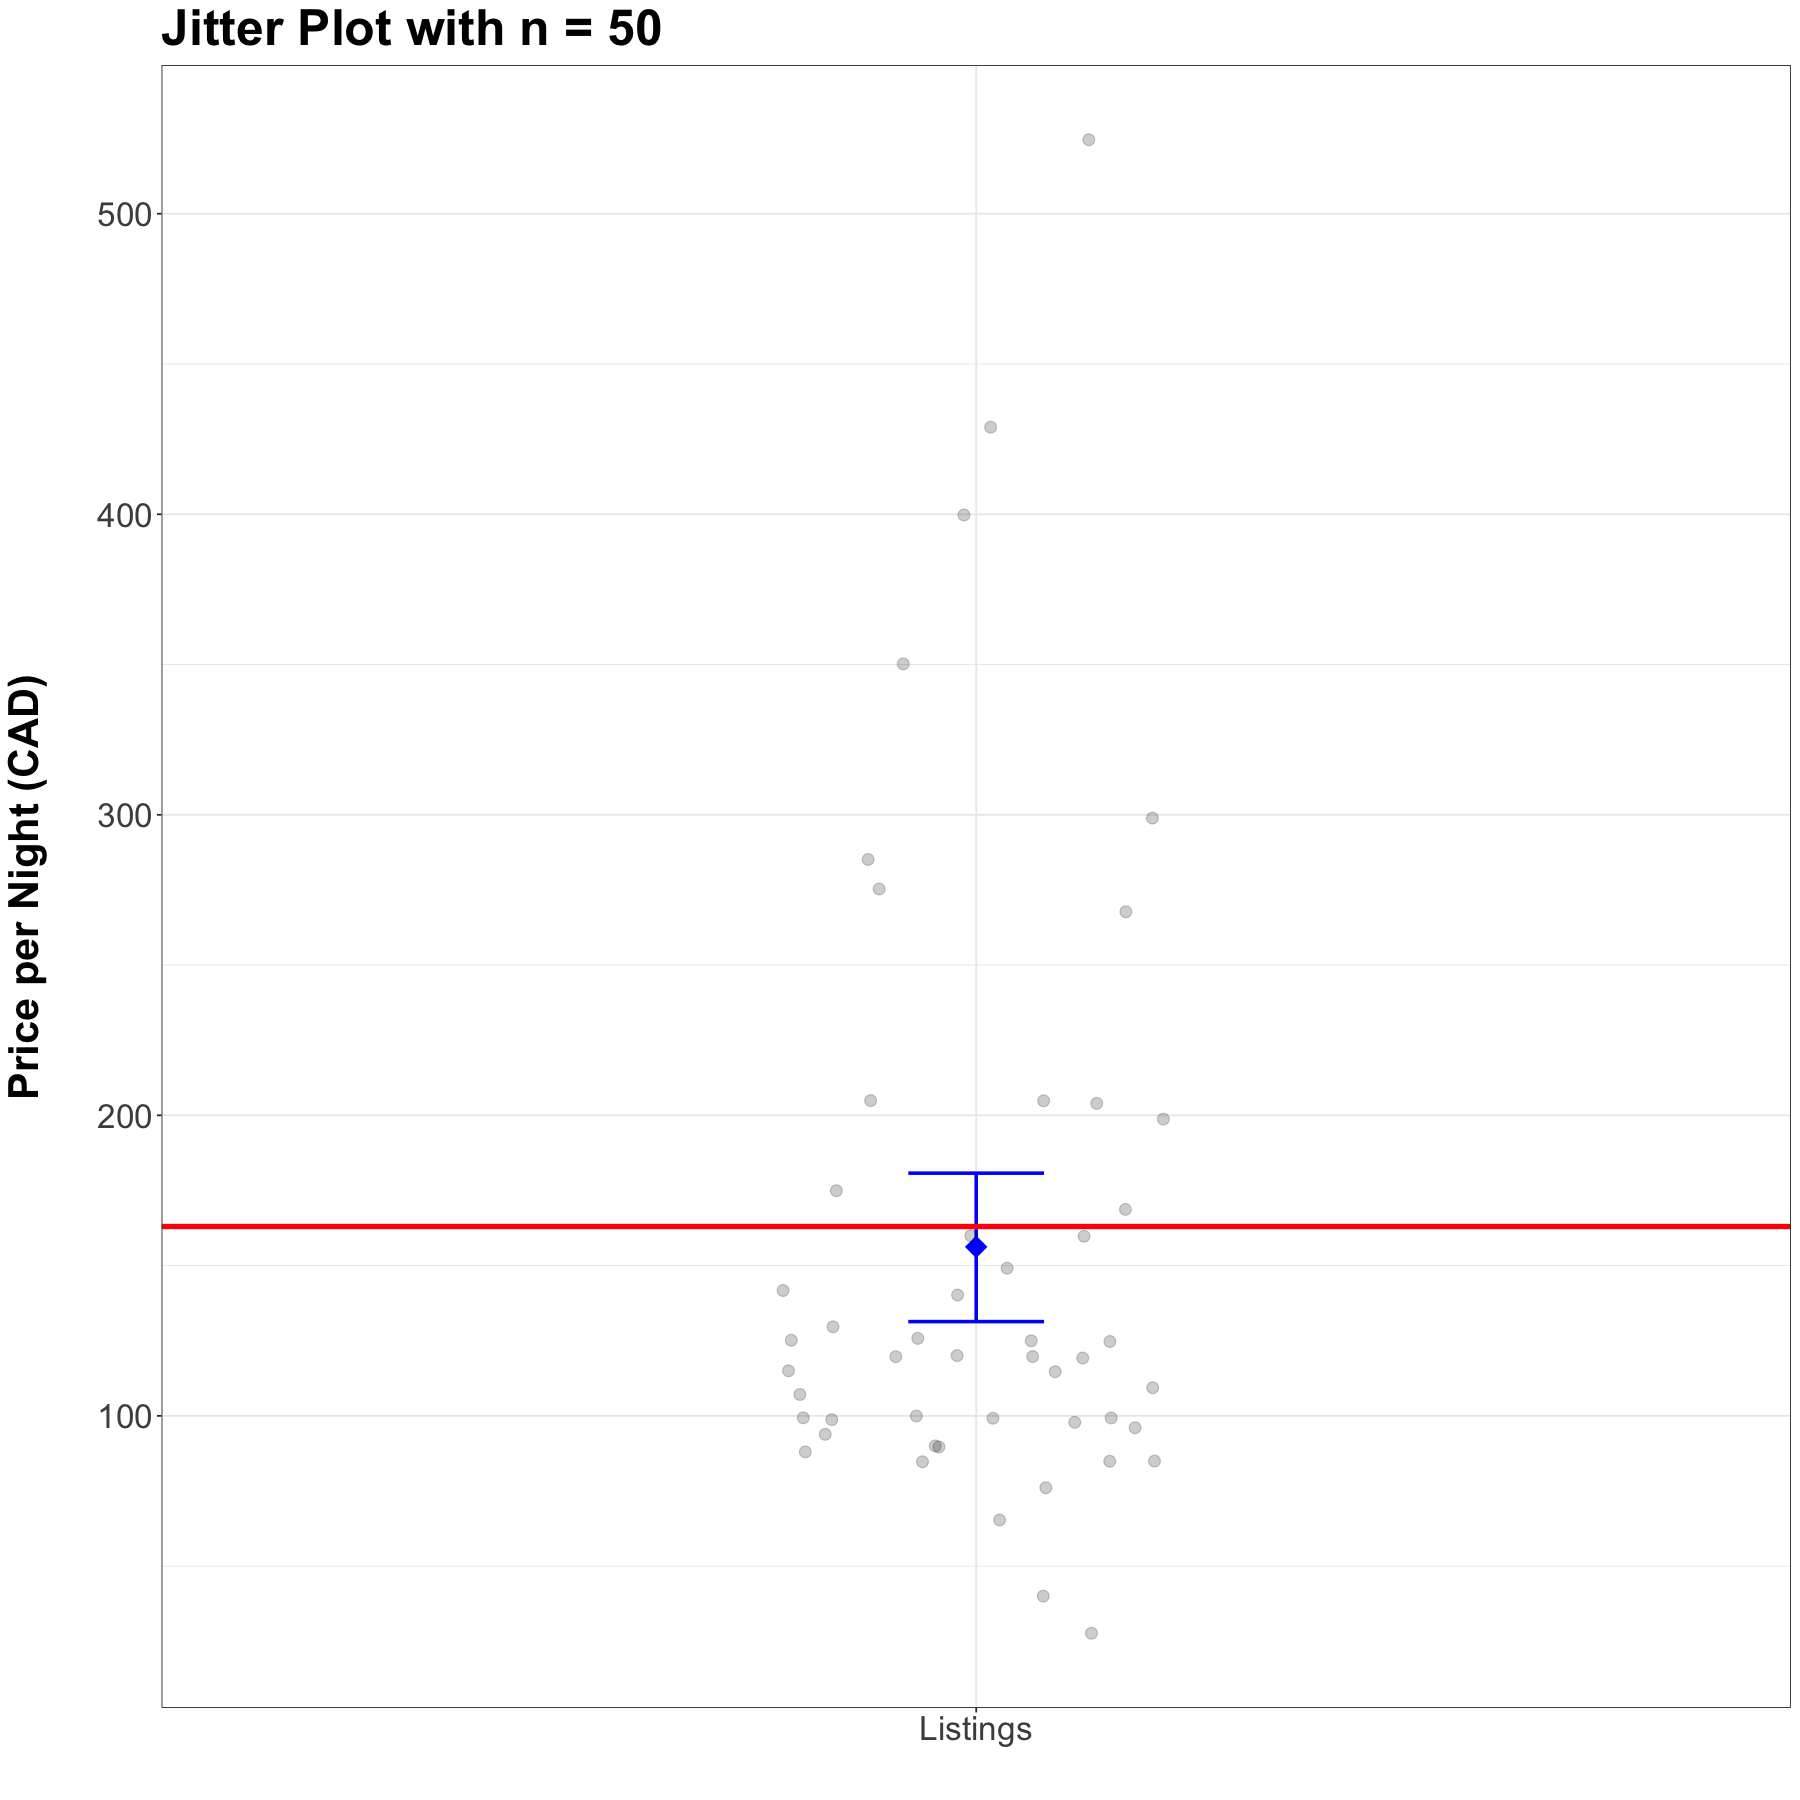

In [31]:
sample_n50_jitter_plot <- ggplot(sample_n50, aes(x = "Listings", y = price)) +
  stat_summary(fun = mean, geom = "point", shape = 18, size = 6, color = "blue") +
  geom_errorbar(data = bootstrap_ci_n50, aes(
    x = "Listings",
    y = mean(sample_n50$price),
    ymin = lower_ci, ymax = upper_ci
  ), size = 1, color = "blue", width = 0.1) +
  labs(x = "", y = "Price per Night (CAD)\n") +
  geom_hline(yintercept = 163.01, color = "red", size = 1.5) +
  ggtitle("Jitter Plot with n = 50") +
  theme_bw() +
  geom_jitter(alpha = 0.2, width = 0.15, size = 3) +
  theme(
    text = element_text(size = 25),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
  )
sample_n50_jitter_plot

We can see in the plot above that $\mu_{\text{price}}$ is captured by `bootstrap_ci_n50`.

### 3.3. A large sample of $n = 300$:

In [32]:
set.seed(1234) # For reproducibility.
sample_n300 <- rep_sample_n(listings, size = 300) |>
  select(replicate, id, price)
sample_n300

replicate,id,price
<int>,<dbl>,<dbl>
1,15037603,115
1,8556170,99
1,32477935,350
⋮,⋮,⋮
1,40598848,779
1,28331525,150
1,11550687,40


The sample mean $\hat{\mu}_{\text{price}}$ is:

In [33]:
sample_n300 |>
  summarise(mean_price = round(mean(price), 2))

replicate,mean_price
<int>,<dbl>
1,161.34


Then, using `sample_n300`, we obtain our 95% bootstrap confidence interval with $b = 1,000$ `bootstrap_estimates`:

In [34]:
set.seed(2021) # For reproducibility.
bootstrap_ci_n300 <- sample_n300 |>
  specify(response = price) |>
  generate(reps = 1000, type = "bootstrap") |>
  calculate(stat = "mean") |>
  get_confidence_interval(level = 0.95, type = "percentile")
bootstrap_ci_n300

lower_ci,upper_ci
<dbl>,<dbl>
146.167,179.4488


Finally, the respective jitter plot.

In [35]:
sample_n300_jitter_plot <- ggplot(sample_n300, aes(x = "Listings", y = price)) +
  stat_summary(fun = mean, geom = "point", shape = 18, size = 6, color = "blue") +
  geom_errorbar(data = bootstrap_ci_n300, aes(
    x = "Listings",
    y = mean(sample_n300$price),
    ymin = lower_ci, ymax = upper_ci
  ), size = 1, color = "blue", width = 0.1) +
  labs(x = "", y = "Price per Night (CAD)\n") +
  geom_hline(yintercept = 163.01, color = "red", size = 1.5) +
  ggtitle("Jitter Plot with n = 300") +
  theme_bw() +
  geom_jitter(alpha = 0.2, width = 0.15, size = 3) +
  theme(
    text = element_text(size = 25),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
  )

Now, we compare the jitter plots of both sample sizes.

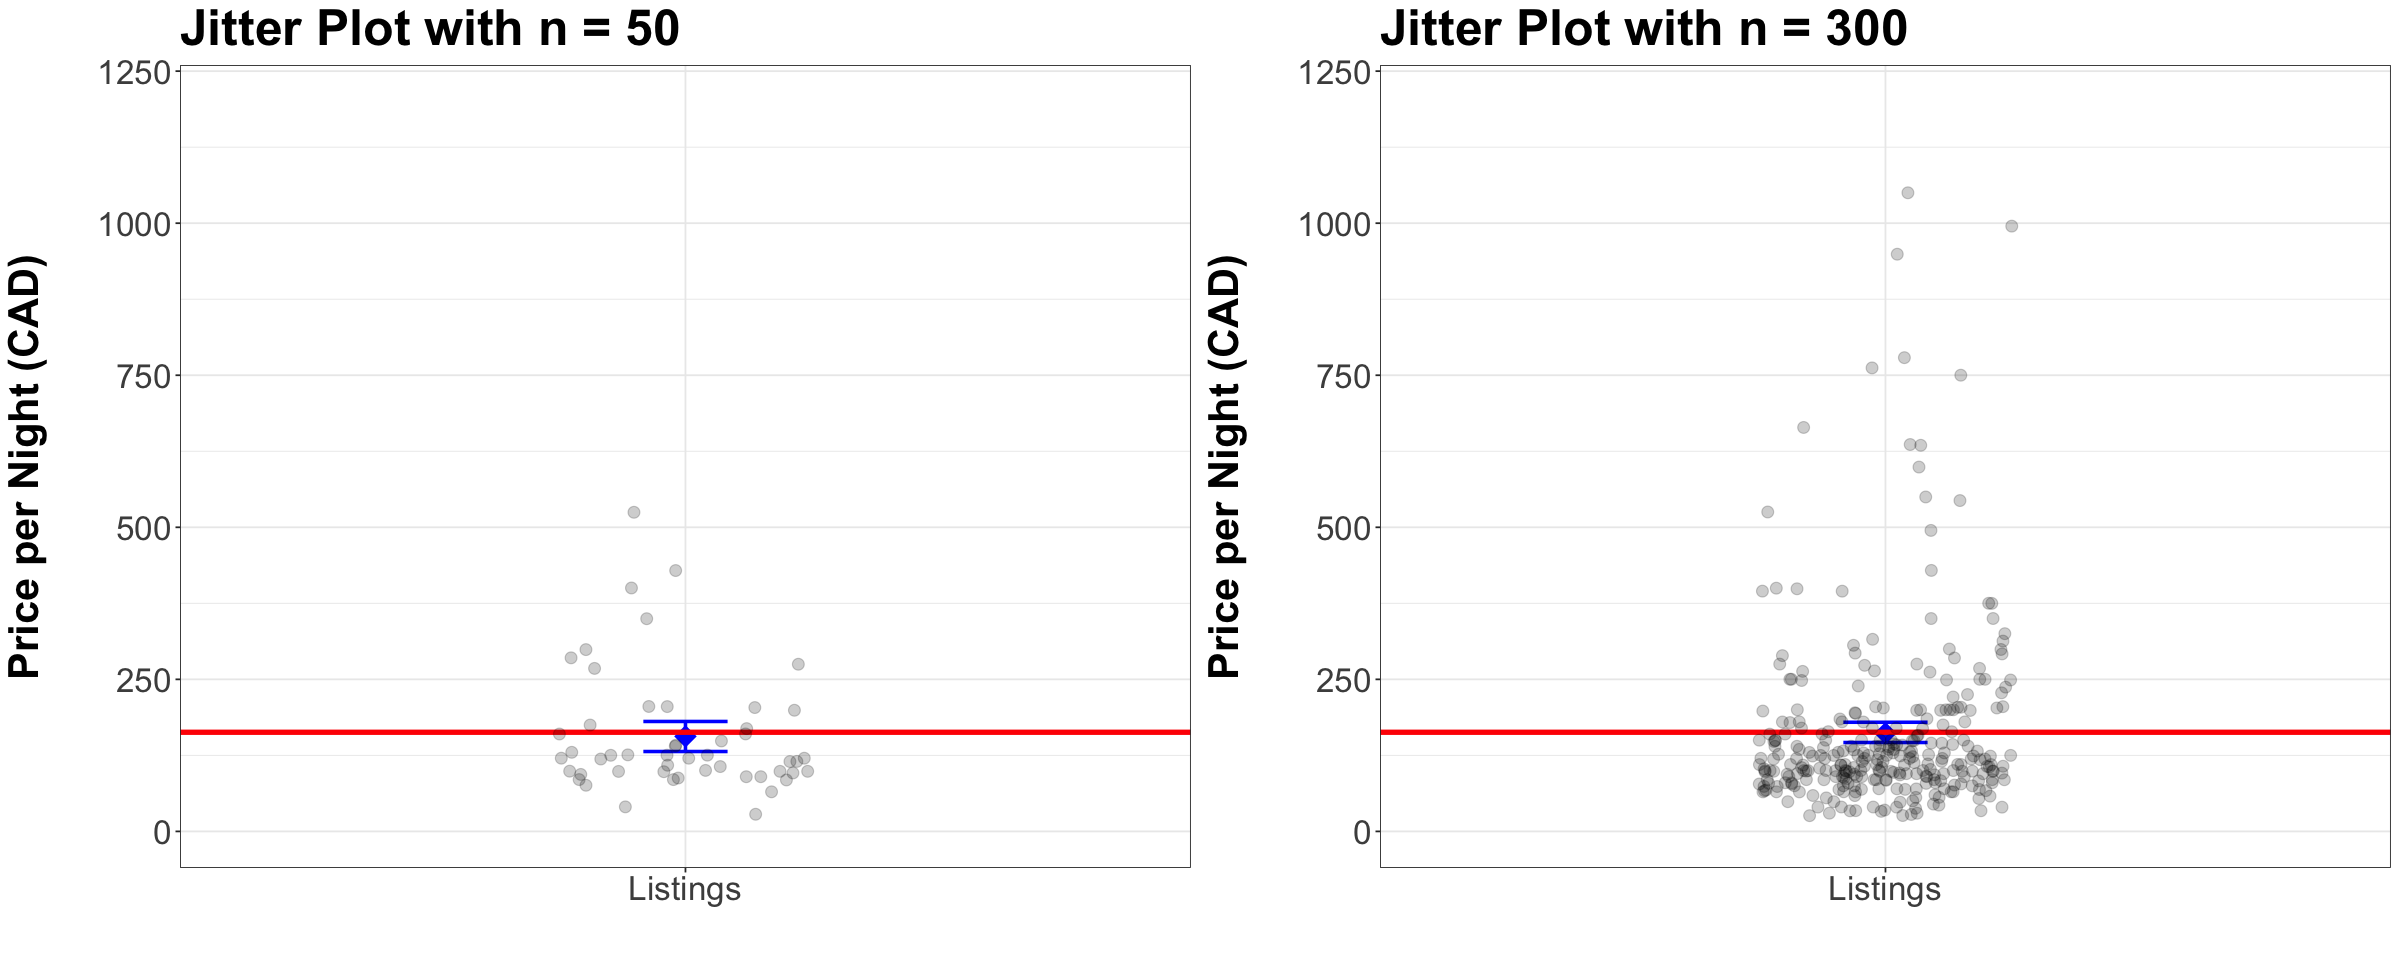

In [36]:
options(repr.plot.width = 20, repr.plot.height = 8)
plot_grid(sample_n50_jitter_plot + coord_cartesian(ylim = c(0, 1200)), sample_n300_jitter_plot + coord_cartesian(ylim = c(0, 1200)), ncol = 2)

Both 95% confidence intervals are **accurate**, since they capture the true $\mu_{\text{price}}$. Nonetheless, the interval for $n = 300$ is narrower. Hence, we can see that increasing our simple size makes our interval **more precise** while still keeping the same confidence level.

Note an important thing for the jitter plot with $n = 300$: **overplotting is quite evident**. We can overcome this issue with another class of plots: **violins plots**.

### 3.4. Violin Plots

Violin plots are basically empirical density plots. They show frequency patterns of our data in terms of the variable of interest.

In [37]:
sample_n50_violin_plot <- ggplot(sample_n50, aes(x = "Listings", y = price)) +
  geom_violin() +
  stat_summary(fun = mean, geom = "point", shape = 18, size = 6, color = "blue") +
  geom_errorbar(data = bootstrap_ci_n50, aes(
    x = "Listings",
    y = mean(sample_n50$price),
    ymin = lower_ci, ymax = upper_ci
  ), size = 1, color = "blue", width = 0.1) +
  labs(x = "", y = "Price per Night (CAD)\n") +
  geom_hline(yintercept = 163.01, color = "red", size = 1.5) +
  ggtitle("Violin Plot with n = 50") +
  theme_bw() +
  theme(
    text = element_text(size = 25),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
  )

sample_n300_violin_plot <- ggplot(sample_n300, aes(x = "Listings", y = price)) +
  geom_violin() +
  stat_summary(fun = mean, geom = "point", shape = 18, size = 6, color = "blue") +
  geom_errorbar(data = bootstrap_ci_n300, aes(
    x = "Listings",
    y = mean(sample_n300$price),
    ymin = lower_ci, ymax = upper_ci
  ), size = 1, color = "blue", width = 0.1) +
  labs(x = "", y = "Price per Night (CAD)\n") +
  geom_hline(yintercept = 163.01, color = "red", size = 1.5) +
  ggtitle("Violin Plot with n = 300") +
  theme_bw() +
  theme(
    text = element_text(size = 25),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
  )

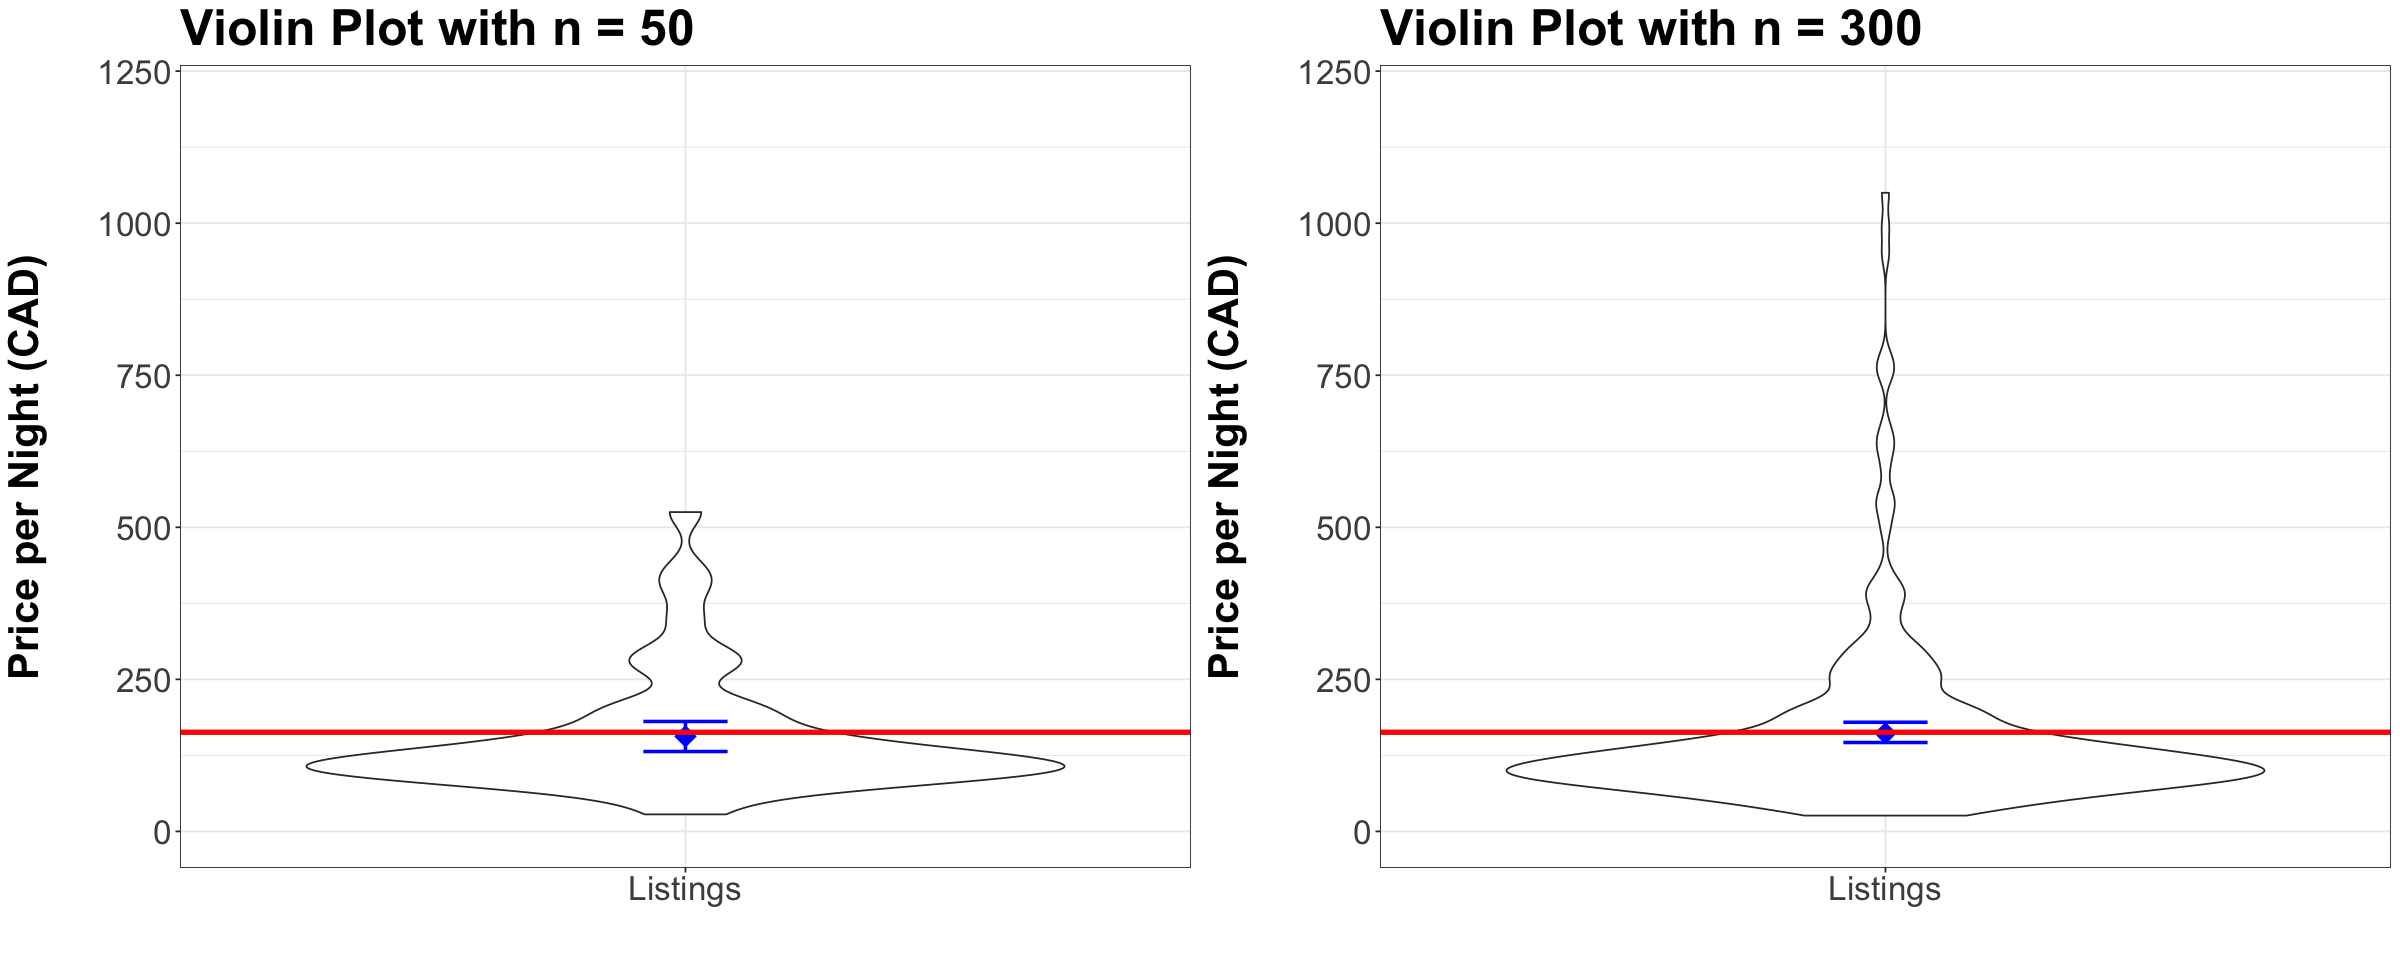

In [38]:
plot_grid(sample_n50_violin_plot + coord_cartesian(ylim = c(0, 1200)), sample_n300_violin_plot + coord_cartesian(ylim = c(0, 1200)), ncol = 2)

## 4. Estimation Recap

- A sample statistic is not equal to a population parameter. However, a sample that is representative enough can provide an accurate and precise estimate.
- We would report this sample estimate with a confidence bound around it.
- Since we cannot sample from a population multiple times, we instead bootstrap from the one sample we have to estimate the sampling variability.

## 5. Acknowledgements

- [Data Science in a box](https://github.com/rstudio-education/datascience-box) by Mine Cetinkaya-Rundel
- [Inference in 3 hours](https://github.com/AllenDowney/CompStats) by Allan Downey
- [Modern Dive: An Introduction to Statistical and Data Sciences via R](https://moderndive.com/index.html) by Chester Ismay and Albert Y. Kim